In [1]:
## import dependencies 
import tensorflow as tf
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time
import os 
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## importing dependencies 
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS 

## define influxdb paramters
token = "A1hvR7pmPINW66Wuxbb7dpwR74TukBJIC7IuP3ADhr4xTx0Zzx-JZxzgInUUFbikMsg_bNo2TI4QnbXnUIOkDg=="
org = "ThirdYearProject"
bucket = "de75cd94d8127ada"

## connect to influxdb
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)

In [3]:
## query data

query_api = client.query_api()

query1_train = 'from(bucket:"MicrosoftData")\
|> range(start:  2015-01-01T00:00:00Z, stop: 2016-11-01T11:59:59Z)\
|> filter(fn: (r) => r._measurement == "Network Prediction"\
and r.Channel == "channel_1144" and r.Segment == "31")\
|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
|> keep(columns: ["_time", "Q-Factor"])'


def dataReady(query):
    data = query_api.query_data_frame(query)
    data.set_index("_time", inplace=True)
    data.index = pd.to_datetime(data.index)
    data.drop('result', axis=1, inplace=True)
    data.drop('table', axis=1, inplace=True)
    return data

data1  = dataReady(query1_train)

In [4]:
data1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Q-Factor,35074.0,13.319445,0.503416,10.65,13.12,13.54,13.72,14.25


In [5]:
data1.head()

,Q-Factor
_time,
2015-02-02 12:00:00+00:00,12.56
2015-02-02 12:15:00+00:00,12.54
2015-02-02 12:30:00+00:00,12.55
2015-02-02 12:45:00+00:00,12.56
2015-02-02 13:00:00+00:00,12.60


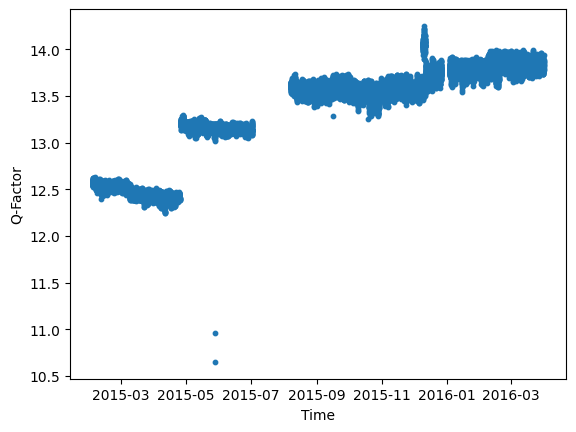

In [7]:
plt.scatter(data1.index, data1['Q-Factor'], s=10)
plt.xlabel('Time')
plt.ylabel('Q-Factor')
plt.show()

In [8]:
#function to create input features
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data #expanding data into tensors 

## required parameters
WINDOW_SIZE = 360
BATCH_SIZE = 64
SHUFFLE_BUFFER = 35000

In [9]:
## converting data to numpy for better/faster processing 
time_index_data1 = np.array(data1.index)
data1_np = np.array(data1["Q-Factor"])
#time_index_data2 = np.array(data2.index)
#data2_np = np.array(data2["Q-Factor"])

In [10]:
#splitting train into train/validation 
def splitData(data, time_index):
    n=len(data)
    train_data = data[:int(n*0.7)]
    train_time = time_index[:int(n*0.7)]
    val_data = data[int(n*0.7):int(n*0.75)]
    val_time = time_index[int(n*0.7):int(n*0.75)]
    test_data = data[int(n*0.75):]
    test_time = time_index[int(n*0.75):]
    return train_data, train_time, val_data, val_time, test_data, test_time

train_data1, train_time1, val_data1, val_time1, test_data1, test_time1 = splitData(data1_np, time_index_data1)
#train_data2, train_time2, val_data2, val_time2, test_data2, test_time2 = splitData(data2_np, time_index_data2)

In [11]:
# generating input and output features for training and testing set 
def tensorData(train_data, val_data):
    tensor_train_data = tf.expand_dims(train_data, axis=-1)
    tensor_val_data = tf.expand_dims(val_data, axis=-1)

    tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
    tensor_val_dataset = ts_data_generator(tensor_val_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
    return tensor_train_dataset, tensor_val_dataset

tensor_train_dataset1, tensor_val_dataset1 = tensorData(train_data1, val_data1)
#tensor_train_dataset2, tensor_val_dataset2 = tensorData(train_data2, val_data2)

Epoch 1/10
378/378 [==============================] - 160s 397ms/step - loss: 1.9988 - mae: 2.3396 - val_loss: 0.3113 - val_mae: 0.7457
Epoch 2/10
378/378 [==============================] - 166s 422ms/step - loss: 0.1427 - mae: 0.4301 - val_loss: 0.1152 - val_mae: 0.3905
Epoch 4/10
378/378 [==============================] - 146s 369ms/step - loss: 0.1077 - mae: 0.3600 - val_loss: 0.0967 - val_mae: 0.3395
Epoch 5/10
378/378 [==============================] - 159s 403ms/step - loss: 0.0677 - mae: 0.2403 - val_loss: 0.0507 - val_mae: 0.1557
Epoch 6/10
378/378 [==============================] - 153s 388ms/step - loss: 0.0410 - mae: 0.1482 - val_loss: 0.0486 - val_mae: 0.1648
Epoch 7/10
378/378 [==============================] - 158s 399ms/step - loss: 0.0333 - mae: 0.1241 - val_loss: 0.0445 - val_mae: 0.1624
Epoch 8/10
378/378 [==============================] - 159s 399ms/step - loss: 0.0274 - mae: 0.1053 - val_loss: 0.0358 - val_mae: 0.1528
Epoch 9/10
378/378 [============================

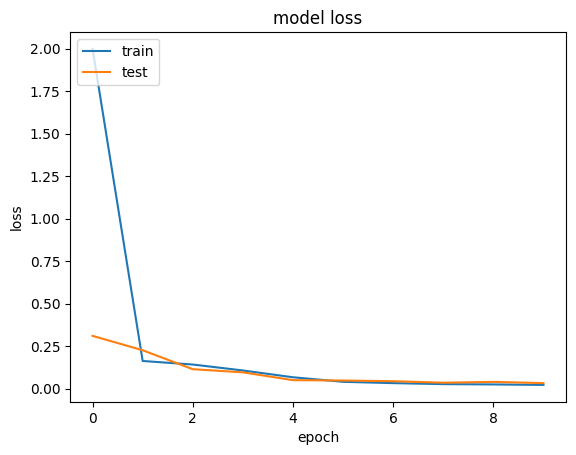

In [12]:
# building model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu",
        input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),

    tf.keras.layers.LSTM(64, return_sequences=True), 

    tf.keras.layers.Dense(30, activation="relu"),  

    tf.keras.layers.Dense(10, activation="relu"), 

    tf.keras.layers.Dense(1)])

# optimiser algorithm adjust weights of network's neurons and learning rate
# reduces loss and improves overall accuracy
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
   #lambda epoch: 1e-8*10**(epoch))
    
optimiser = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiser, metrics=["mae"])

## training model
history = model.fit(tensor_train_dataset1, epochs=10, validation_data=tensor_val_dataset1)

#determining optimum learning rate for model
#lrs = 1e-8 * (10 ** (np.arange(10))/20)
#plt.semilogx(lrs, history.history['loss'])
#plt.axis([1e-8, 1e-3, 0, 10])

## losses of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
## making a prediction
def model_forecast(model, data, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)#returns learned label for each object in array 
    #dimensions:(no. windows, window size, no. features)
    return forecast

#adding dimension to test_data so it matches 3 dimensional forecast
forecast = model_forecast(model, data1_np[...,np.newaxis], WINDOW_SIZE, BATCH_SIZE)

In [14]:
predicted_values = forecast[int(len(data1_np)*0.75)-WINDOW_SIZE:-1,-1,0]#batch size (: all) time slice (-1 last one) features (only one, so first one)

In [15]:
error = tf.keras.metrics.mean_absolute_error(test_data1, predicted_values).numpy()
print(error)

0.04593792


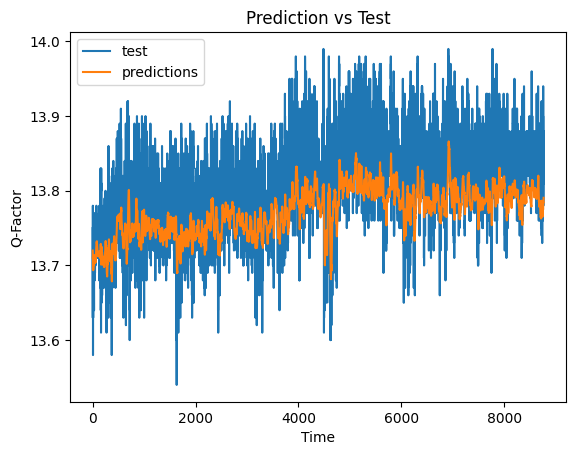

In [16]:
# comparison graph 
plt.plot(test_data1)
plt.plot(predicted_values)
plt.title('Prediction vs Test')
plt.ylabel('Q-Factor')
plt.xlabel('Time')
plt.legend(['test', 'predictions'], loc='upper left')
plt.show()